# Quantum error correction hands-on session
## Future Horizons workshop, 15 May 2024

## Setup

Run `pip install pymatching` to install a decoding algorithm we will need later.

In [1]:
import numpy as np
import pymatching
import matplotlib.pyplot as plt

## Background

### Recap: the decoding problem

- Stabilizer group $\mathcal S$ with associated $[\![n,k,d]\!]$ code
- Measure $m$ stabilizer generators
- **The decoding problem**
  - Input: error syndrome $\sigma(E) \in \{-,1,1\}^m$
  - Output: recovery operator $R \in \mathcal P_n$ such that $\sigma(R) = \sigma(E)$
  - Success if $RE \in \mathcal S$

### Binary symplectic form

- General form of an $n$-qubit Pauli operator
  - $r \in \{ 0, 1, 2, 3 \}$
  - $\vec a, \vec b \in \mathbb F_2^n$
  - $P = i^r X^{\vec a} Z^{\vec b}$
- $X^{\vec a} = X^{\vec a_0} \otimes X^{\vec a_1} \otimes \ldots \otimes X^{\vec a_n}$
- $Z^{\vec b} = Z^{\vec b_0} \otimes Z^{\vec b_1} \otimes \ldots \otimes Z^{\vec b_n}$

- Ignoring the phase, we can represent a Pauli operator $P$ as a length $2n$ vector: $\vec p = \begin{bmatrix} \vec a | \vec b \end{bmatrix}^T \in \mathbb F_2^{2n}$
- Two Pauli operators commute iff their symplectic product is zero
- $\Omega = \begin{bmatrix} 0 & I_n \\ I_n & 0 \end{bmatrix}$
- $(\vec p, \vec q) := \vec p^T \Omega \vec q$

- Example: $P = X \otimes Z \otimes I \otimes Y$, $Q = Z \otimes Z \otimes X \otimes Z$
- In binary symplectic form: $\vec p = \begin{bmatrix} 1001 | 0101 \end{bmatrix}^T$, $\vec q = \begin{bmatrix} 0010 | 1101 \end{bmatrix}^T$
- $(\vec p, \vec q) = \begin{bmatrix} 1001 | 0101 \end{bmatrix}\begin{bmatrix} 0 & I_n \\ I_n & 0 \end{bmatrix} \begin{bmatrix} 0010 | 1101 \end{bmatrix}^T = \begin{bmatrix} 1001 | 0101 \end{bmatrix} \cdot \begin{bmatrix} 1101 | 0010 \end{bmatrix} = 0$

### CSS codes

- Stabilizer code whose stabilizer group can be generated by purely $X$-type and $Z$-type operators
- Pure $X$-type operator: tensor product of Pauli $X$ and $I$
- Pure $Z$-type operator: tensor product of Pauli $Z$ and $I$
- Example: $[\![4,2,2]\!]$ code, $\mathcal S = \langle X_1X_2X_3X_4, Z_1Z_2Z_3Z_4 \rangle$

- For CSS codes the decoding problem breaks into two parts
  - Measure $X$-type stabilizer generators to diagnose $Z$ errors
  - Measure $Z$-type stabilizer generators to diagnose $X$ errors

- Parity-check matrix $H \in \mathbb F_2^{m \times 2n}$
- Each row is a stabilizer generator in binary symplectic form
- Pauli error $E \in \mathcal P_n$ with binary symplectic form $\vec e \in \mathbb F_2^{2n}$
- Error syndrome $\sigma(E) = H \Omega \vec e$ (where we represent a $-1$ measurement outcome as 1 and a $1$ measurement outcome as 0)

- For CSS codes, parity-check matrix has block diagonal form: $H = \begin{bmatrix} H_X & 0 \\ 0 & H_Z \end{bmatrix}$
- $H_X \in \mathbb F_2^{m_X\times n}, H_Z \in \mathbb F_2^{m_Z\times n}$
- $H \Omega \vec e = H \Omega [\vec e_X | \vec e_Z]^T = [H_X \vec e_Z | H_Z \vec e_X]^T$

- Example: $[\![4,2,2]\!]$ code, $H = \begin{bmatrix} 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 1 & 1 &1 \end{bmatrix}$

- **Upshot**: we can consider the decoding problems for $X$ and $Z$ errors separately

## Task: Decoding the toric code [Kit03,DKLP02]

- The toric code is a CSS code with a geometric definition
- Consider a tiling of an orientable manifold
- Associate qubits with edges
- Associate $X$-type stabilizer generators with vertices
  - For each vertex $v$ we have a stabilizer $A_v = \bigotimes_{e : v \in e} X_e$, where $X_e$ acts as Pauli $X$ on the qubit on edge $e$ and identity everywhere else
- Associate $Z$-type stabilizer generators with faces
  - For each face $f$ we have a stabilizer $B_f = \bigotimes_{e \in f} Z_e$, where $Z_e$ acts as Pauli $Z$ on the qubit on edge $e$ and identity everywhere else

<img src="img/TC.jpg" alt="Stabilizer generators of the toric code" width="400"/>

### Question 1
Consider an $L \times L$ square tiling of the torus. 
Write a function that returns the $H_X$ parity-check matrix of the toric code defined on the tiling. 

*Hint*: this is the vertex to edge adjacency matrix of the tiling. 
The code has parameters $[\![2L^2,2,L]\!]$. 
All the stabilizer generators should be weight 4.

In [2]:
def pcm(L):
    n = 2*L**2
    m = L**2
    Hx = np.zeros((m, n), dtype=np.int8)
    for x in range(L):
        for y in range(L):
            v = x + y*L
            ex = 2*v
            ey = 2*v+1
            vnx = (x - 1) % L + y*L
            enx = 2*vnx
            vny = x + ((y - 1) % L) * L  
            eny = 2*vny + 1
            Hx[v, ex] = 1
            Hx[v, ey] = 1
            Hx[v, enx] = 1
            Hx[v, eny] = 1
    return Hx

In [3]:
L = 3
pcm(L)

array([[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]], dtype=int8)

### Question 2

Consider an error model where a $Z$ error occurs on each qubit independently with probability $p \in [0,1]$. 
This is called the iid phase-flip error model. 
Write code a function to sample $Z$ errors from this distribution (in binary symplectic form). 
Use your $H_X$ matrix to compute the error syndrome.

*Hint*: you only need to consider the $Z$ part of the vector, i.e., it should be length $n$.

In [4]:
def sample_error(n, p):
    e = np.zeros(n, dtype=np.int8)
    for i in range(n):
        if np.random.rand() < p:
            e[i] = 1
    return e

In [5]:
L = 3
n = 2*L**2
Hx = pcm(L)
p = 0.05
e = sample_error(n, p)
synd = Hx @ e % 2

In [6]:
synd

array([0, 0, 0, 0, 1, 1, 0, 0, 0], dtype=int8)

### Question 3

The logical $X$ operators of the toric code have the following form:
<img src="img/Lx.jpg" alt="Logical X operators of the toric code" width="800"/>

(Technically they are non-contractible loops in the dual tiling.)

Write a function that returns a matrix $L_X \in \mathbb F_2^{2\times n}$ representing these operators in binary symplectic form.

In [7]:
def logicals(L):
    n = 2*L**2
    Lx = np.zeros((2, n), dtype=np.int8) 
    for x in range(L):
        Lx[0, 2*x + 1] = 1
        Lx[1, 2*x*L] = 1
    return Lx

In [8]:
logicals(3)

array([[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=int8)

### Question 4

Fix $L$ and $p$ and estimate the logical error rate of the toric code using `pymatching` by running 1000 Monte Carlo trials. 
`pymatching` is a fast implementation of the minimum-weight perfect matching decoder [DKLP02,Hig22,HG23].

*Hint*
- Use `matching = pymatching.Matching.from_check_matrix(Hx)` to construct the decoder.
- Use `recovery = matching.decode(syndrome)` to find the recovery operator for a given syndrome.
- To check if a logical error has occurred, test whether `recovery + error` commutes with `Lx`.

In [9]:
trials = 1000
L = 3
p = 0.05
Hx = pcm(L)
Lx = logicals(L)
matching = pymatching.Matching.from_check_matrix(Hx)
fails = 0
for _ in range(trials):
    e = sample_error(n, p)
    synd = Hx @ e % 2
    recov = matching.decode(synd) 
    fail = not np.all(Lx @ (recov + e) % 2 == 0)
    fails += fail


### Question 5

Plot the logical error rate for toric codes with lengths $L \in \{5, 7, 9, 11\}$ and iid phase-flip noise with $p \in [0.06, 0.12]$.
The error threshold $p_{\rm th}$ is the value of $p$ for which the curves intersect.
For $p < p_{\rm th}$, the logical error rate is exponentially suppressed as the $L$ increases.

What is your estimate of the error threshold?

*Hint*: you may need ~10k trials to see a clear crossing. 
Sometimes it is easier to see on a log plot.

In [10]:
ps = np.linspace(0.06, 0.12, 21)
Ls = range(5, 12, 2)
trials = 10000
data = {L : [] for L in Ls}
for L in Ls:
    for p in ps:
        Hx = pcm(L)
        Lx = logicals(L)
        matching = pymatching.Matching.from_check_matrix(Hx)
        n = 2*L**2
        fails = 0
        for _ in range(trials):
            e = sample_error(n, p)
            synd = Hx @ e % 2
            recov = matching.decode(synd) 
            fail = not np.all(Lx @ (recov + e) % 2 == 0)
            fails += fail
        data[L] += [fails / trials]


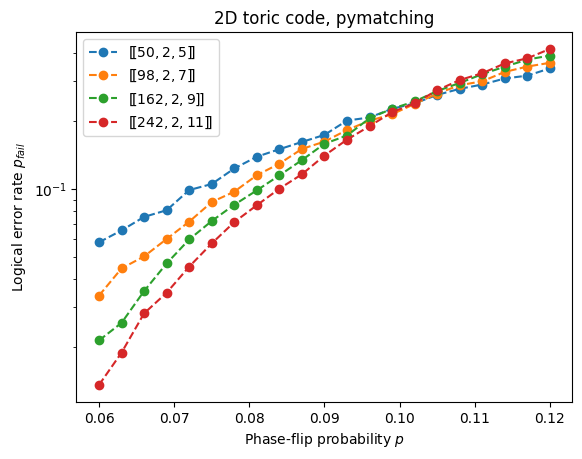

In [11]:
for k, v in data.items():  
    plt.plot(ps, v, '--o', label=f'$[\![{2*k**2},2,{k}]\!]$')
plt.xlabel('Phase-flip probability $p$')
plt.ylabel('Logical error rate $p_{fail}$')
plt.yscale('log')
plt.title("2D toric code, pymatching")
plt.legend()

## Extension 1: Try a different decoder

See if the results change with a different decoder!

- Run `pip install bposd`. This will install Roffe's implementation of the BP+OSD decoder [PK21,RWB+20].
- Initialize the decoder as follows
```python
bpd=bposd_decoder(
    Hx,#the parity check matrix
    error_rate=p,
    channel_probs=[None], #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=n, #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=7 #the osd search depth
)
```
- Use `bpd.decode(syndrome)` to find the recovery operator.
- Try changing the parameters of the decoder and comparing the results.

In [12]:
from ldpc import bposd_decoder

In [13]:
from tqdm import tqdm

In [14]:
ps = np.linspace(0.06, 0.12, 21)
Ls = range(5, 12, 2)
trials = 10000
data = {L : [] for L in Ls}
for L in Ls:
    for p in tqdm(ps):
        Hx = pcm(L)
        Lx = logicals(L)
        bpd=bposd_decoder(
            Hx,#the parity check matrix
            error_rate=p,
            channel_probs=[None], #assign error_rate to each qubit. This will override "error_rate" input variable
            max_iter=n, #the maximum number of iterations for BP)
            bp_method="ms",
            ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
            osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
            osd_order=7 #the osd search depth
        )
        n = 2*L**2
        fails = 0
        for _ in range(trials):
            e = sample_error(n, p)
            synd = Hx @ e % 2
            recov = bpd.decode(synd)
            fail = not np.all(Lx @ (recov + e) % 2 == 0)
            fails += fail
        data[L] += [fails / trials]

100%|██████████| 21/21 [04:39<00:00, 13.31s/it]


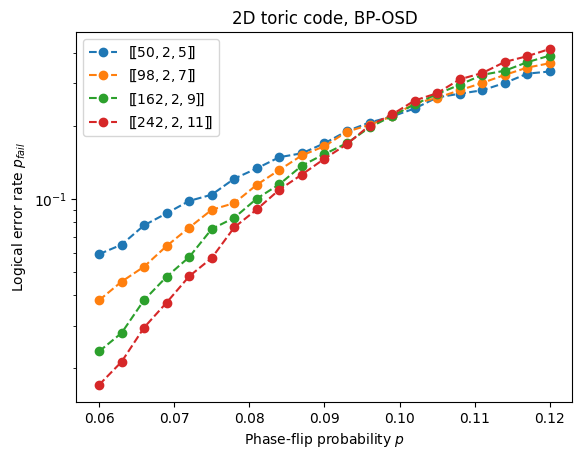

In [15]:
for k, v in data.items():  
    plt.plot(ps, v, '--o', label=f'$[\![{2*k**2},2,{k}]\!]$')
plt.xlabel('Phase-flip probability $p$')
plt.ylabel('Logical error rate $p_{fail}$')
plt.yscale('log')
plt.title("2D toric code, BP-OSD")
plt.legend()

## Extension 2: Estimating the error threshold of the toric code with measurement errors

In the previous simulations we have assumed that stabilizer measurement is perfect. This is not the case in real systems!

Consider a noise model with iid phase-flips (with probability $p$) on the qubits and where each measurement result is flipped with probability $p$.
One can show that the toric code decoding problem in this case is essentially equivalent to decoding an iid phase-flip channel but now with the code defined on a simple cubic tiling instead of a square tiling [DKLP02].

Your task is to estimate the error threshold in this case.

*Hints*

- The definition of the stabilizers of the same and this stabilizer code is actually the 3D toric code with parameters $[\![3L^3, 3, L]\!]$, where we assume an $L \times L \times L$ tiling of the 3-torus by cubes.
- You need a new $H_X$, which will be the vertex to edge adjacency matrix of the 3D tiling. All the $X$-type stabilizer generators will be weight 6.
- The logical $X$ operators are now sheet-like operators. For each of the three Euclidean axes, take a normal plane that bisects cubes. The logical operator acts with $X$ on all the qubits on edges that touch the plane.
- Once you have $H_X$ and $L_X$ the simulation proceeds in the same way. 
- I would recommend using `pymatching` as it is faster.
- Try $p \in [0.01, 0.05]$

In [16]:
def pcm_3d(L):
    n = 3*L**3
    m = L**3
    Hx = np.zeros((m, n), dtype=np.int8)
    for x in range(L):
        for y in range(L):
            for z in range(L):
                v = x + y*L + z*L**2
                ex = 3*v
                ey = 3*v+1
                ez = 3*v+2
                vnx = (x - 1) % L + y*L + z*L**2
                enx = 3*vnx
                vny = x + ((y - 1) % L) * L + z*L**2  
                eny = 3*vny + 1
                vnz = x + y*L + ((z - 1) % L)*L**2
                enz = 3*vnz + 2
                Hx[v, ex] = 1
                Hx[v, ey] = 1
                Hx[v, ez] = 1
                Hx[v, enx] = 1
                Hx[v, eny] = 1
                Hx[v, enz] = 1
    return Hx

In [17]:
pcm_3d(2)

array([[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0],
       [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 1]], dtype=int8)

In [18]:
def logicals_3d(L):
    n = 3*L**3
    Lx = np.zeros((3, n), dtype=np.int8)
    for i in range(L):
        for j in range(L):
            vxy = i + j*L
            vxz = i + j*L**2
            vyz = i*L + j*L**2
            Lx[0, 3*vxy + 2] = 1
            Lx[1, 3*vxz + 1] = 1
            Lx[2, 3*vyz] = 1
    return Lx

In [19]:
L = 2
logicals_3d(L)

array([[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0]], dtype=int8)

In [20]:
ps = np.linspace(0.01, 0.05, 5)
Ls = range(3, 8, 2)
trials = 10000
data = {L : [] for L in Ls}
for L in Ls:
    for p in ps:
        Hx = pcm_3d(L)
        Lx = logicals_3d(L)
        n = 3*L**3
        matching = pymatching.Matching.from_check_matrix(Hx)
        fails = 0
        for _ in range(trials):
            e = sample_error(n, p)
            synd = Hx @ e % 2
            recov = matching.decode(synd) 
            fail = not np.all(Lx @ (recov + e) % 2 == 0)
            fails += fail
        data[L] += [fails / trials]

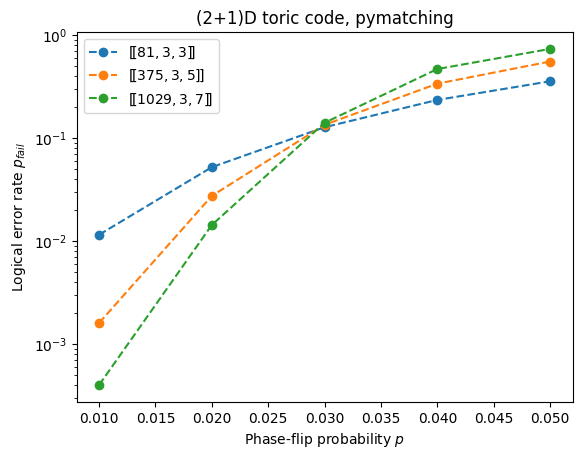

In [21]:
for k, v in data.items():  
    plt.plot(ps, v, '--o', label=f'$[\![{3*k**3},3,{k}]\!]$')
plt.xlabel('Phase-flip probability $p$')
plt.ylabel('Logical error rate $p_{fail}$')
plt.yscale('log')
plt.title("(2+1)D toric code, pymatching")
plt.legend()

## Further reading

- Estimating the error threshold of the toric code under circuit-level noise https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb

## References
- [Kit03] A. Yu. Kitaev, “Fault-tolerant quantum computation by anyons”, *Annals of Physics* 303(1), 2-30 (2003). https://doi.org/10.1016/S0003-4916(02)00018-0
- [DKLP02] Eric Dennis, Alexei Kitaev, Andrew Landahl, and John Preskill, “Topological quantum memory”, *Journal of Mathematical Physics* 43, 4452-4505 (2002). https://doi.org/10.1063/1.1499754 
- [Hig22] Oscar Higgott, "PyMatching: A Python Package for Decoding Quantum Codes with Minimum-Weight Perfect Matching", *ACM Transactions on Quantum Computing* 3(3), 1–16 (2022). https://doi.org/10.1145/3505637 
- [HG23] Oscar Higgott and Craig Gidney, "Sparse Blossom: correcting a million errors per core second with minimum-weight matching", *arXiv preprint* (2023). https://doi.org/10.48550/arXiv.2303.15933 
- [PK21] Pavel Panteleev and Gleb Kalachev, "Degenerate Quantum LDPC Codes With Good Finite Length Performance", *Quantum* 5, 585 (2021). https://doi.org/10.22331/q-2021-11-22-585 
- [RWB+20] Joschka Roffe, David R. White, Simon Burton, and Earl Campbell, "Decoding across the quantum low-density parity-check code landscape", *Physical Review Research* 2, 043423 (2020). https://doi.org/10.1103/PhysRevResearch.2.043423 